In [17]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import pickle

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW, Optimizer
import torchvision.models as models
from torchvision import transforms as T
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR
import torch.nn.init as init
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import torch.multiprocessing as mp


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import lightly

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')


In [2]:
EXP_DIR = '../exp/'

In [41]:
def get_score(y_true, y_pred):
    score = mean_squared_error(y_true, y_pred)
    return np.sqrt(score)

In [72]:
def load_result_csv(num_exp):
    exp_dir = EXP_DIR + f'{num_exp}/'
    ret = {}
    ret['submission'] = pd.read_csv(exp_dir + 'submission.csv')
    ret['oof'] = pd.read_csv(exp_dir + 'oof_df.csv')
    if os.path.exists(exp_dir + 'test_probs.csv'):
        ret['test_probs'] = pd.read_csv(exp_dir + 'test_probs.csv')
    if os.path.exists(exp_dir + 'both_oof.csv'):
        ret['both_oof'] = pd.read_csv(exp_dir + 'both_oof.csv')
    return ret

In [73]:
results = load_result_csv('exp058')
results.keys()

dict_keys(['submission', 'oof', 'test_probs', 'both_oof'])

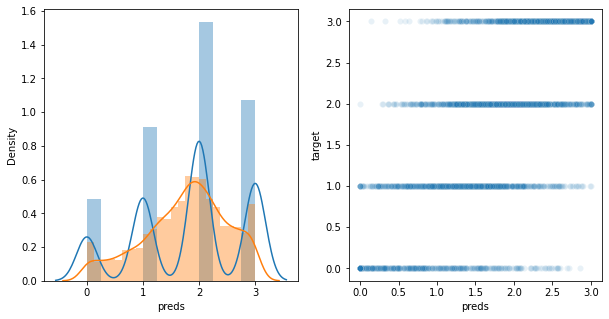

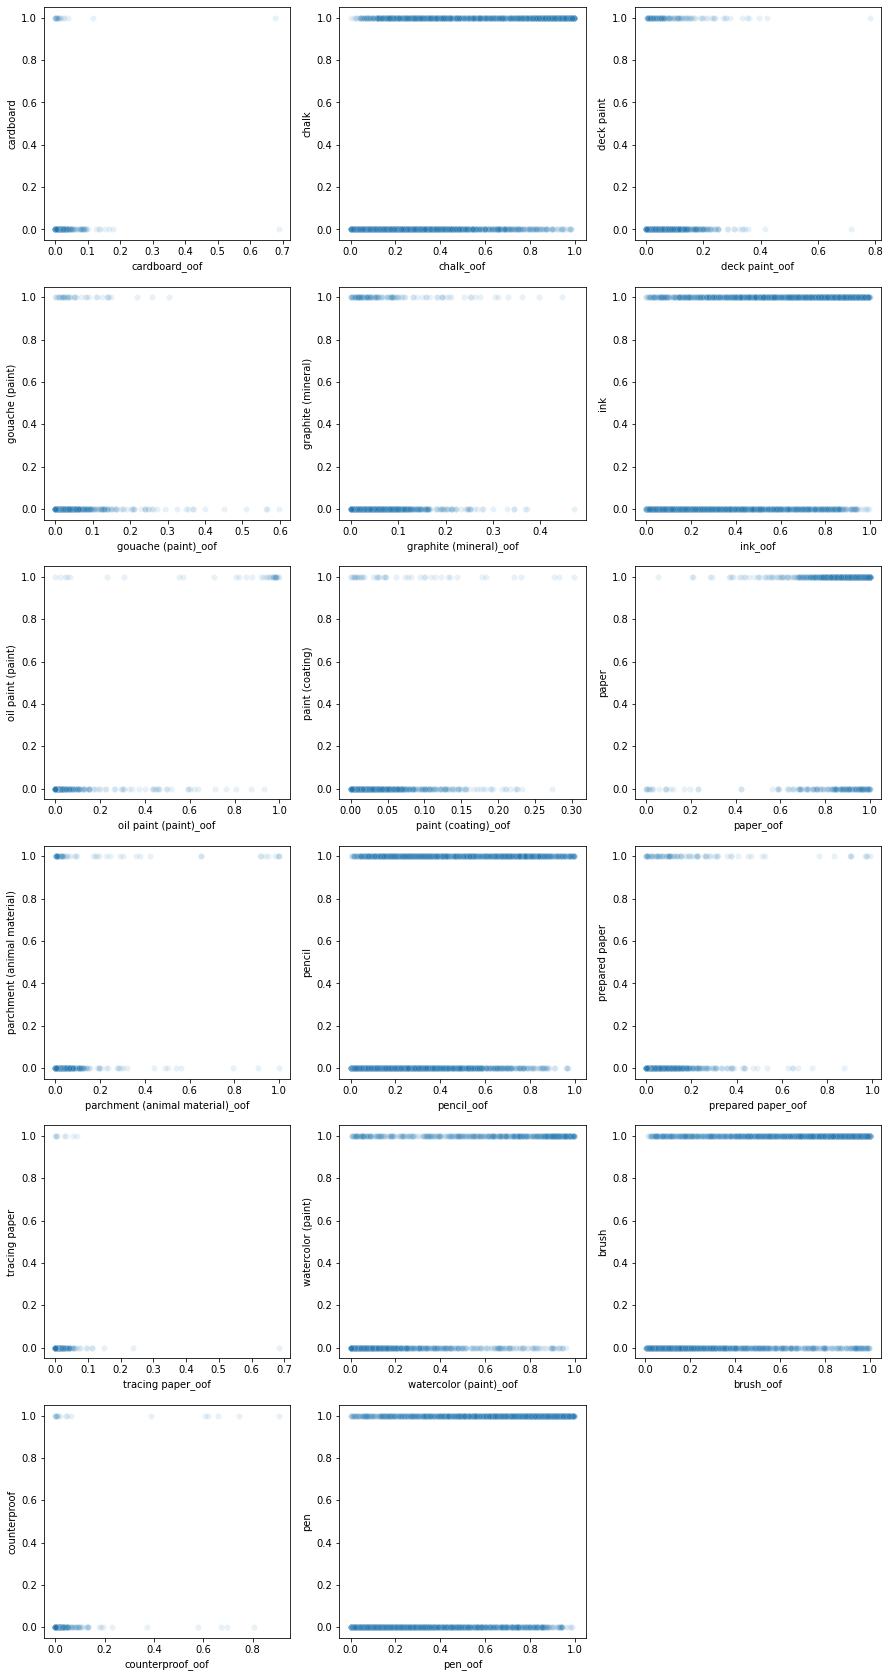

In [74]:
def plot_result(results):
    # oof
    submission = results['submission']
    oof_df = results['oof']
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    sns.distplot(oof_df['target'], ax=ax1)
    sns.distplot(oof_df['preds'], ax=ax1)
    
    ax2 = fig.add_subplot(1, 2, 2)
    sns.scatterplot(oof_df['preds'], oof_df['target'], ax=ax2, alpha=0.1)
    
    plt.show()
    
    if 'both_oof' in results.keys():
        both_oof = results['both_oof']
        
        pretrain_target = ['cardboard', 'chalk', 'deck paint', 'gouache (paint)', 'graphite (mineral)', 'ink', 'oil paint (paint)', 'paint (coating)', 'paper', 'parchment (animal material)', 'pencil', 'prepared paper', 'tracing paper', 'watercolor (paint)']
        pretrain_target +=  ['brush', 'counterproof', 'pen']
        
        pretrain_target_oof = [f'{t}_oof' for t in pretrain_target]
        
        fig = plt.figure(figsize=(15, 30))
        for i in range(len(pretrain_target)):
            ax = fig.add_subplot(6, 3, i + 1)
            sns.scatterplot(both_oof[pretrain_target_oof[i]], both_oof[pretrain_target[i]], alpha=0.1, ax=ax)
        plt.show()
    
    
    
plot_result(results)

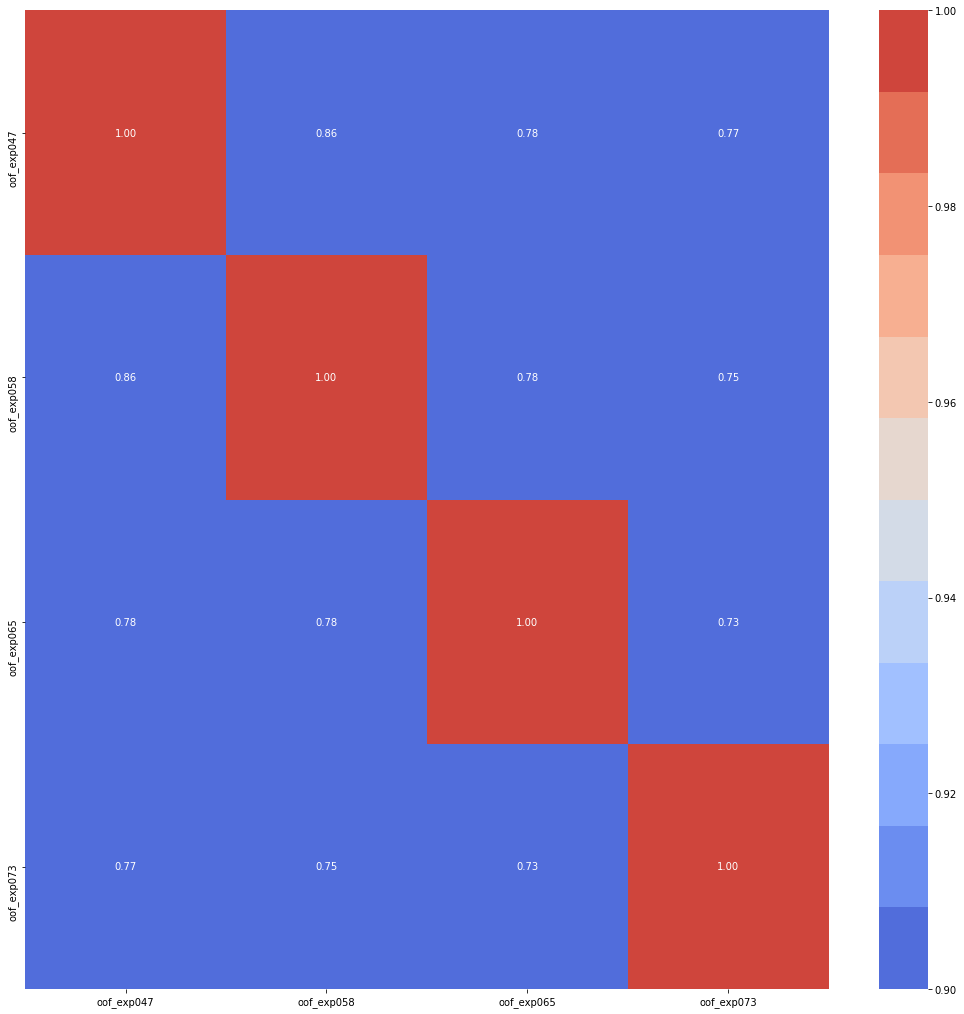

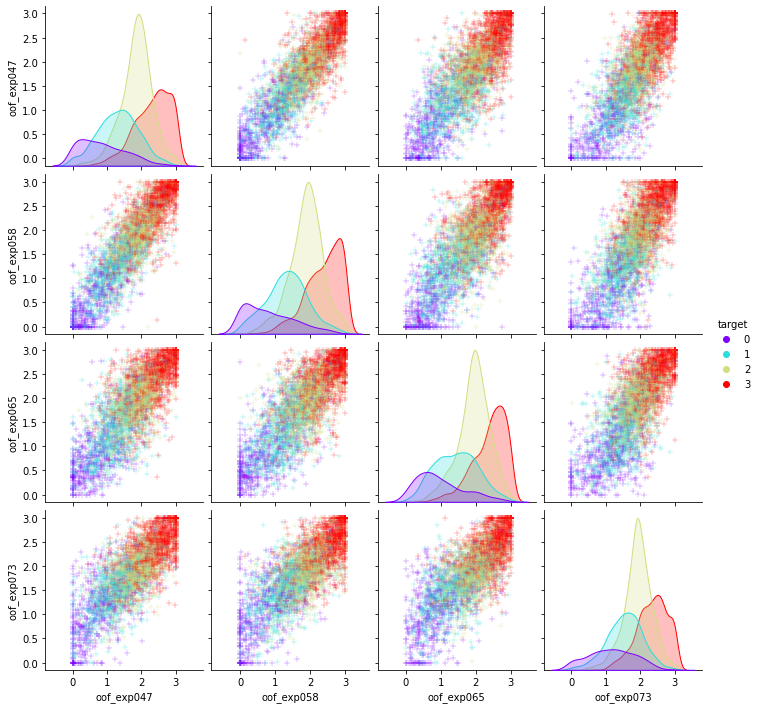

CV score: 0.6817123626070595


In [85]:
def plot_relations(exps):
    results = [load_result_csv(i) for i in exps]
    
    oof_df = pd.DataFrame()
    oof_columns = []
    for exp, result in zip(*(exps, results)):
        oof = result['oof']
        oof_columns.append(f'oof_{exp}')
        oof_df[f'oof_{exp}'] = oof['preds']
        
    oof_corr = oof_df[oof_columns].corr()
    
    fig = plt.figure(figsize=(18, 18))
    ax1 = fig.add_subplot(1, 1, 1)
    sns.heatmap(oof_corr, cmap= sns.color_palette('coolwarm', 12), annot=True, fmt='.2f', vmin = 0.9, vmax = 1, ax=ax1)
    
    plt.show()
    
    oof_df['target'] = results[0]['oof']['target']

    sns.pairplot(oof_df, hue='target',
                 palette='rainbow',
                 markers='+',
                 plot_kws={'alpha': 0.5})
    
    plt.show()
    
    # cv score
    test_df = pd.DataFrame()
    train_target = None
    test_columns = []
    for exp, result in zip(*(exps, results)):
        sub = result['submission']
        test_df[f'pred_{exp}'] = sub['target']
        test_columns.append(f'pred_{exp}')
        if train_target is None:
            train_target = result['oof']['target'].values

    test_df['target'] = test_df[test_columns].mean(axis=1)
    oof_df['target'] = oof_df[oof_columns].mean(axis=1)
#     print(oof_df['target'].values)
#     print(train_target)
    score = get_score(train_target, oof_df['target'].values)
    print(f'CV score: {score}')
        
    
plot_relations(['exp047', 'exp058', 'exp065', 'exp073'])